In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from os.path import join, isfile
# from hwtmode.data import load_labels
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, accuracy_score
from sklearn.calibration import calibration_curve

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def load_labels(start, end, label_path, run_freq, file_format):
    labels = []
    for run_date in pd.date_range(start, end, freq=run_freq[0], closed="left"):
        file_name = join(label_path, f'model_labels_{run_date.strftime("%Y-%m-%d_%H%M")}.{file_format}')
        if isfile(file_name):
            if file_format == 'parquet':
                labels.append(pd.read_parquet(file_name))
            elif file_format == 'csv':
                labels.append(pd.read_csv(file_name))
        else:
            continue

    return pd.concat(labels)

def brier_skill_score(y_true, y_pred):
    bs_climo = np.mean((y_true.mean() - y_true) ** 2)
    bs = brier_score_loss(y_true, y_pred)
    return 1 - bs / bs_climo

def brier_score_decomposition(y_true, y_pred):
    base_rate = y_true.mean()
    probs = np.arange(0,1.1,0.1)
    bs_rel, bs_res = 0, 0
    
    for k, prob in enumerate(probs[:-1]):
        mask = ( y_pred >= probs[k] ) & ( y_pred < probs[k+1] )
        if mask.sum() < 1: continue
        
        bin_num_points = mask.sum()
        bin_base_rate = y_true[mask].mean()
        bs_rel += bin_num_points * np.mean( ( y_pred[mask] - bin_base_rate )**2 )        
        bs_res += bin_num_points * np.mean( ( bin_base_rate - base_rate )**2 )
        
    bs_rel, bs_res = bs_rel / y_pred.size, bs_res / y_pred.size
    bs_unc = base_rate * (1.0 - base_rate)
    
    return (bs_rel, bs_res, bs_unc)

In [3]:
# what versions of the CNN, GMM, DNN are in this file?
# how much of the WRF training dataset was used for analysis, and what versions of CNN/GMM/DNN were used

# this file has all the CNN, GMM, DNN predictions for *all* storms
labels = load_labels("2013-06-25", "2013-12-31", "/glade/work/cbecker/HWT/HWT_evaluation_WRF/HWT_2013_hand_labled_holdout/labels/", "daily", "parquet") # all storms in WRF dataset

# get labels here...
hand_labeled = pd.read_csv('/glade/work/sobash/HWT_mode/model_cnn_test2_addstorms2_noaugval_newtrain/predictions_test.csv') # all storms in hand labeled dataset
hand_labeled = hand_labeled.loc[hand_labeled['run_date'] >= "2013-06-25"]

categories_int = {'Q1':0, 'Q2':0, 'S1':1, 'S2':0, 'S3':1, 'D1':2, 'D2':2}
categories = {'Q1':'QLCS', 'Q2': 'QLCS', 'S1':'Supercell', 'S2':'QLCS', 'S3':'Supercell', 'D1':'Disorganized', 'D2':'Disorganized'}

hand_labeled['new_label_int'] = hand_labeled['label'].apply(lambda x: categories_int[x])
hand_labeled['new_label'] = hand_labeled['label'].apply(lambda x: categories[x])

hand_labeled['unique_id'] = hand_labeled['run_date'].astype(str) + '.' + hand_labeled['track_id'].astype(str) + '.' + hand_labeled['track_step'].astype(str)
labels['unique_id'] = labels['Run_Date'].astype(str).apply(lambda x: x[:10]) + '.' + labels['Track_ID'].apply(lambda x: str(x[-3:]).lstrip("0")) + '.' + labels['Duration'].astype(str)

matched_labels = labels[labels['unique_id'].isin(hand_labeled.loc[:, 'unique_id'])] #extract only the storms with hand labels
matched_labels.loc[:, 'true_label'] = hand_labeled.loc[:, 'new_label'].values.copy()
matched_labels.loc[:, 'true_label_int'] = hand_labeled.loc[:, 'new_label_int'].values.copy()

model_names = ['CNN_1', 'DNN_1', 'SS']
modes = ['QLCS', 'Supercell', 'Disorganized']
for mode in modes:
    matched_labels.loc[:, f'true_label_{mode}_int'] = np.where(matched_labels[f'true_label'] == mode, 1.0, 0.0)

prob_cols = [col for col in matched_labels.columns if 'prob' in col]
matched_labels.loc[:, prob_cols] = np.where(matched_labels[prob_cols] > 0.999, 0.999, matched_labels[prob_cols])

# read LR predictions
lr_predictions = pd.read_pickle('lr_predictions_test_storms.pk')
lr_prob_values = lr_predictions[['LR_QLCS_prob', 'LR_Supercell_prob', 'LR_Disorganized_prob']].values
lr_prob_argmax = np.argmax(lr_prob_values, axis=1)

for mode in modes: matched_labels[f'LR_{mode}_prob'] = lr_predictions[f'LR_{mode}_prob'].values
matched_labels['LR_label'] = [ modes[n] for n in np.argmax(lr_prob_values, axis=1) ]
matched_labels['LR_label_prob'] = lr_prob_values[range(lr_prob_argmax.size), lr_prob_argmax]

# compute AVG predictions
for mode in modes:
    matched_labels['AVG_%s_prob'%mode] = ( matched_labels['CNN_1_%s_prob'%mode] + matched_labels['DNN_1_%s_prob'%mode] + matched_labels['LR_%s_prob'%mode]) / 3.0
    matched_labels['AVG_label'] = matched_labels['CNN_1_label']


/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on

In [4]:
metrics = {'auc': roc_auc_score, 'brier_score': brier_score_loss, 'brier_skill_score': brier_skill_score, 'brier_score_decomposition': brier_score_decomposition,\
           'calibration_curve': calibration_curve, 'confusion_matrix': confusion_matrix, 'base_rate':'' }
all_metrics = {}

for metric_name, metric in metrics.items():
    all_metrics[metric_name] = {}
    
    for model in model_names + ['LR', 'AVG']:
        for mode in modes:
            y_true_int, y_pred_prob = matched_labels[f'true_label_{mode}_int'], matched_labels[f'{model}_{mode}_prob']
            y_true, y_pred = matched_labels['true_label'], matched_labels[f'{model}_label']

            if metric_name == 'confusion_matrix':
                all_metrics[metric_name][model] = metrics[metric_name](y_true, y_pred)
            elif metric_name == 'calibration_curve':
                all_metrics[metric_name][f"{model}_{mode}"] = metrics[metric_name](y_true_int, y_pred_prob, n_bins=8)
            elif metric_name == 'base_rate':
                all_metrics[metric_name][f"{model}_{mode}"] = y_true_int.mean()
            else:
                all_metrics[metric_name][f"{model}_{mode}"] = metrics[metric_name](y_true_int, y_pred_prob)
                
#all_metrics

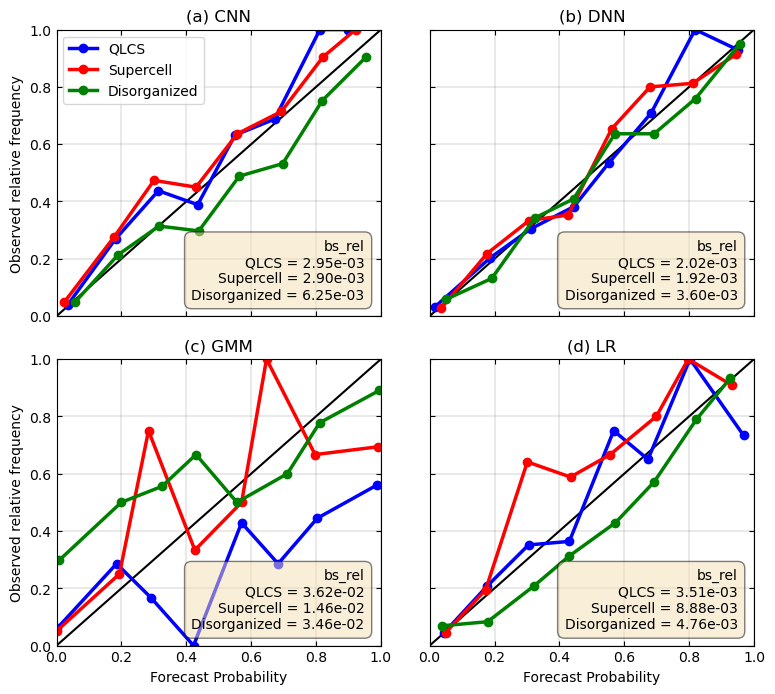

In [72]:
#fig = plt.figure(figsize=(8,8))
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(9,8))
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axes = axes.flatten()

line_colors = ['blue', 'red', 'green']
for n,model in enumerate(['CNN_1','DNN_1','SS', 'LR']):
    ax = axes[n]
    ax.plot([0,1], [0,1], color='k')
    ax.grid(linewidth=0.25, color='gray')
    ax.set_ylim((0,1))
    ax.set_xlim((0,1))
    ax.tick_params(top=True, right=True, direction='in', labelsize=10)
    
    text = '\n'.join( ( 'bs_rel', 'QLCS = %.2e'%(all_metrics['brier_score_decomposition'][model+'_QLCS'][0]),
                        'Supercell = %.2e'%(all_metrics['brier_score_decomposition'][model+'_Supercell'][0]),
                        'Disorganized = %.2e'%(all_metrics['brier_score_decomposition'][model+'_Disorganized'][0])
                      ))
                       
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5, pad=0.5)
    ax.text(0.95, 0.05, text, transform=ax.transAxes, fontsize=10, va='bottom', ha='right', bbox=props)

    for m, mode in enumerate(['QLCS', 'Supercell', 'Disorganized']):
        ax.plot(all_metrics['calibration_curve'][model+'_%s'%mode][1], all_metrics['calibration_curve'][model+'_%s'%mode][0], markersize=6, marker='o', linewidth=2.5, color=line_colors[m], label=mode)
                      
axes[0].legend()
axes[0].set_ylabel('Observed relative frequency')
axes[2].set_ylabel('Observed relative frequency')
axes[2].set_xlabel('Forecast Probability')
axes[3].set_xlabel('Forecast Probability')
axes[0].set_title('(a) CNN')
axes[1].set_title('(b) DNN')
axes[2].set_title('(c) GMM')
axes[3].set_title('(d) LR')

plt.savefig('test_set_reliability.png', bbox_inches='tight')

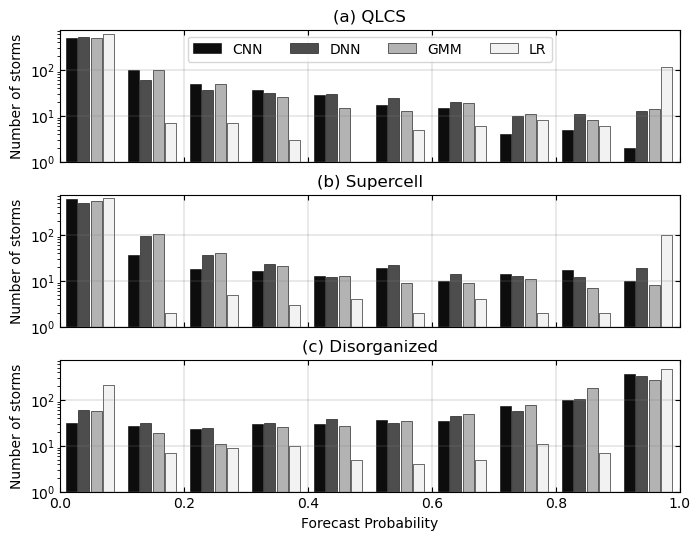

In [69]:
#fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,3))
fig, axes = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(8,6))

fig.subplots_adjust(hspace=0.25, wspace=0.1)
axes = axes.flatten()

for n,mode in enumerate(['QLCS', 'Supercell', 'Disorganized']):
    ax = axes[n]
    n, bins, patches = ax.hist( [ matched_labels[f'CNN_1_{mode}_prob'], matched_labels[f'DNN_1_{mode}_prob'], matched_labels[f'LR_{mode}_prob'], matched_labels[f'SS_{mode}_prob'] ],
                                     bins=np.arange(0,1.01,0.1), log=True, width=0.0175, edgecolor='k', linewidth=0.4, label=['CNN', 'DNN', 'GMM', 'LR'], color=['0.05', '0.3', '0.7', '0.95'])
        
    ax.grid(linewidth=0.25, color='gray')
    ax.set_ylim((1,756))
    ax.set_xlim((0,1))
    ax.set_yticks([1,10,100])
    ax.tick_params(top=True, right=True, direction='in', labelsize=10)
        
axes[0].legend(ncol=4,loc='upper center')

axes[0].set_ylabel('Number of storms')
axes[1].set_ylabel('Number of storms')
axes[2].set_ylabel('Number of storms')

#axes[2].set_ylabel('Observed relative frequency')
#axes[0].set_xlabel('Forecast Probability')
#axes[1].set_xlabel('Forecast Probability')
axes[2].set_xlabel('Forecast Probability')
axes[0].set_title('(a) QLCS', loc='center')
axes[1].set_title('(b) Supercell', loc='center')
axes[2].set_title('(c) Disorganized', loc='center')
#axes[3].set_title('(d) CNN/DNN avg')

plt.savefig('test_set_prob_dist.png', bbox_inches='tight')

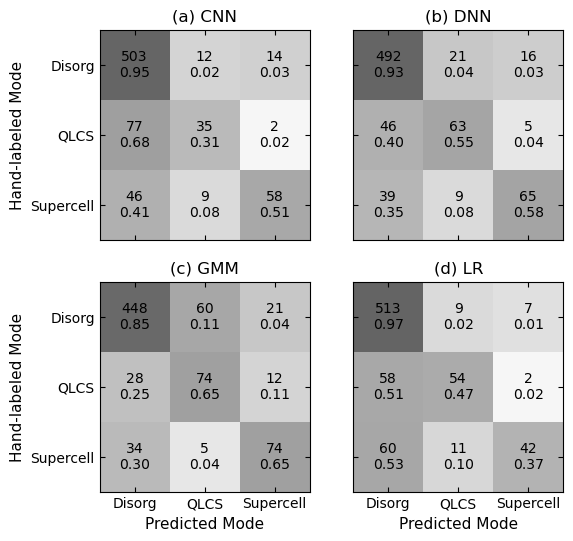

In [71]:
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(6,6))
#fig.subplots_adjust()
axes = axes.flatten()

from matplotlib.colors import LogNorm

for n,model in enumerate(['CNN_1', 'DNN_1', 'SS', 'LR']):
    ax = axes[n]

    ax.imshow(all_metrics['confusion_matrix'][model], cmap=plt.get_cmap('Greys'), norm=LogNorm(vmin=1, vmax=10000))
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Disorg', 'QLCS', 'Supercell']) # are QLCS and supercell flipped?
    
    ax.set_yticks([0,1,2])
    ax.set_yticklabels(['Disorg', 'QLCS', 'Supercell'])
        
    for j in range(3):
        for i in range(3):
            frac = all_metrics['confusion_matrix'][model][j,i] / all_metrics['confusion_matrix'][model][j,:].sum()
            ax.text(i, j, '%d\n%.2f'%( all_metrics['confusion_matrix'][model][j,i], frac ), ha='center', va='center')
            
    ax.tick_params(top=True, right=True, direction='in', labelsize=10)
            
axes[0].set_title('(a) CNN')
axes[1].set_title('(b) DNN')
axes[2].set_title('(c) GMM')
axes[3].set_title('(d) LR')
for n in [0,2]: axes[n].set_ylabel('Hand-labeled Mode', fontsize=11)
for n in [2,3]: axes[n].set_xlabel('Predicted Mode', fontsize=11)

plt.savefig('test_set_conf_matrix.png', bbox_inches='tight')